In [2]:
import pandas as pd
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=64, truncation=True, padding='max_length')

# Read the Excel file
file_path = "data/stockwits/stockwits_crypto.xlsx"
df = pd.read_excel(file_path)


C:\Users\André\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\André\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
def is_valid_text(entry):
    if isinstance(entry, str):
        return True
    if isinstance(entry, list):
        if all(isinstance(item, str) for item in entry):
            return True
        if all(isinstance(item, list) and all(isinstance(sub_item, str) for sub_item in item) for item in entry):
            return True
    return False

#create smaller dataset for testing
df = df.head(100)

# Filter the DataFrame
df = df[df['text'].apply(is_valid_text)]

# Convert to list
posts = df['text'].tolist()

In [7]:
# Predict the sentiment of each post
preds = pipe(posts)
# Add predictions to the DataFrame
df['sentiment'] = preds

                                                 text  label  \
0   if you were curious, price chose the lowest ch...      1   
1              true, not even 10k followers here yet.      1   
2   dogecoin co-founder billy markus hits back at ...      1   
3    i’m curious, do any bulls have a price where ...      1   
4              friday everybody buy 10 more on friday      2   
..                                                ...    ...   
95               i bought moree appes avg up not down      1   
96      don’t fight fight accept our god in your life      2   
97  some great plays from weeks low . locked in pr...      2   
98   i put all i can into this shiba, now sit back...      2   
99   it'll go to 38 in a few hours, guess you coul...      0   

                                            sentiment  
0   {'label': 'Neutral', 'score': 0.9550445675849915}  
1   {'label': 'Neutral', 'score': 0.5679700374603271}  
2   {'label': 'Neutral', 'score': 0.9301873445510864}  
3   {'l

In [26]:
import shap

# Explain the sentiment analysis pipeline with SHAP
explainer = shap.Explainer(pipe)
shap_values = explainer(posts[:10])

PartitionExplainer explainer: 11it [06:33, 39.38s/it]                        


In [27]:
shap_values

.values =
array([array([[ 0.        , -0.00078552, -0.00085678],
              [ 0.        ,  0.01237696,  0.00387594],
              [-0.00326273,  0.07127136, -0.05284131],
              [ 0.00326273,  0.01366281, -0.02425949],
              [ 0.        ,  0.19154815, -0.14297133],
              [ 0.        , -0.0029978 , -0.00909407],
              [ 0.00641563,  0.06388402, -0.03927989],
              [ 0.06971971,  0.05057361, -0.09391243],
              [ 0.03854083, -0.08410574,  0.0373682 ],
              [-0.11467617,  0.30154322, -0.0172494 ],
              [-0.07245773,  0.36698193, -0.15848823],
              [-0.00638161,  0.00399837,  0.02681422],
              [ 0.08894571, -0.08455251,  0.00381291],
              [ 0.08913944,  0.10394987, -0.13965691],
              [ 0.05492912, -0.05419442,  0.00416998],
              [-0.12269998,  0.02304084,  0.07478522],
              [-0.03993334, -0.09149528,  0.1293146 ],
              [ 0.00845839,  0.07034469, -0.05382531],


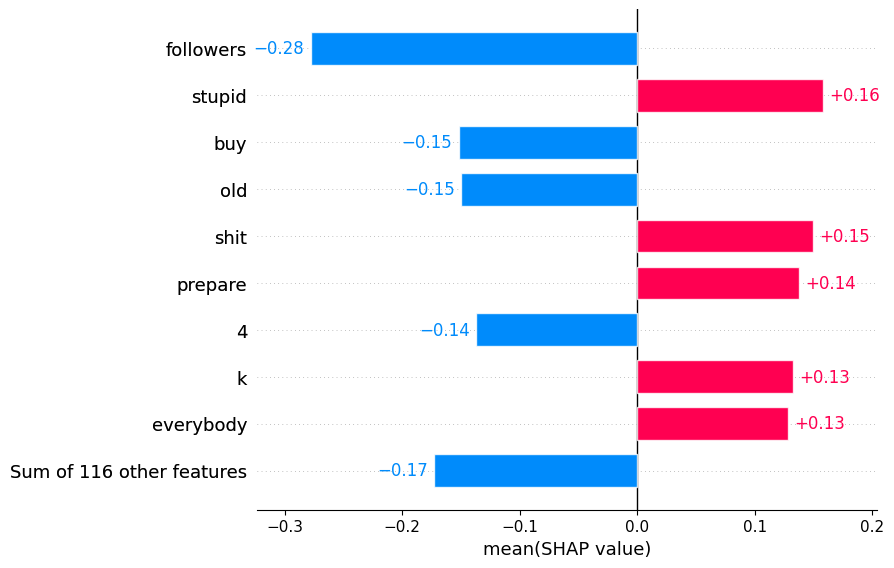

In [29]:
shap.plots.text(shap_values[:, :, "Bullish"])
# Plot the SHAP bar plot
shap.plots.bar(shap_values[:, :, "Bearish"].mean(0))

In [30]:
from flask import Flask, request, jsonify
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
import shap
import pandas as pd

app = Flask(__name__)

# Load the model and tokenizer
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=64, truncation=True, padding='max_length')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data['text']

    # Predict sentiment
    preds = pipe([text])
    sentiment = preds[0]['label']

    # Get SHAP values
    shap_values = get_shap_values([text])
    shap_summary = shap_values.values[0].tolist()  # Convert SHAP values to a list

    # Return prediction and SHAP values
    return jsonify({
        'text': text,
        'sentiment': sentiment,
        'shap_values': shap_summary
    })

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
from flask import Flask, request, jsonify, send_file
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
import shap
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64

app = Flask(__name__)

# Load the model and tokenizer
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=64, truncation=True, padding='max_length')

# Function to get SHAP values
def get_shap_values(texts):
    tokens = tokenizer(texts, return_tensors='pt', max_length=64, truncation=True, padding='max_length')
    def model_predict(inputs):
        outputs = model(**inputs)
        return outputs.logits.detach().numpy()
    explainer = shap.Explainer(model_predict, tokens)
    shap_values = explainer(tokens)
    return shap_values, tokens

# Function to create a SHAP plot and return it as a base64-encoded string
def create_shap_plot(shap_values, tokens):
    shap.summary_plot(shap_values.values, features=tokens, feature_names=tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]), show=False)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return base64.b64encode(buf.read()).decode('utf-8')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data['text']

    # Predict sentiment
    preds = pipe([text])
    sentiment = preds[0]['label']

    # Get SHAP values and tokens
    shap_values, tokens = get_shap_values([text])

    # Create SHAP plot
    shap_plot_base64 = create_shap_plot(shap_values, tokens)

    # Return prediction and SHAP values
    return jsonify({
        'text': text,
        'sentiment': sentiment,
        'shap_plot': shap_plot_base64
    })

if __name__ == '__main__':
    app.run(debug=True)
